In [1]:
# !pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [100]:
import sklearn 

In [101]:
!pip install numpy --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [102]:
import numpy as np                   
import matplotlib.pyplot as plt      
import random                        
from tensorflow.keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used
from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.
# X_train = X_train[:5000,]
# y_train = y_train[:5000,]
# X_test = X_test[:500,]
# y_test = y_test[:500,]
# print(X_test.shape)

In [103]:
from platform import python_version

print(python_version())

3.8.12


In [104]:
x = X_train
y = y_train
x_test = X_test 
y_test = y_test

In [105]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [106]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F #function such as activation,etc
from torch import nn 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from functools import partial
from scipy import stats, interpolate
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
params = {
    'input_size': 784,
    'output_size': 10,
    'hidden_size': 356,
    'dropout_p': 0.4,
    'batch_size': 128,
    'epochs': 60,
    'lr': 1e-4,
}

In [108]:
class MontecarloDropoutNet(nn.Module):
    def __init__(self, params):
        super().__init__() # this calls the intialization of the nn module method.
        self.model_ = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']), # params hidden_Size gives number of hidden nodes to the network
            nn.Dropout(params['dropout_p']),
            nn.Linear(params['hidden_size'], params['output_size']),
            nn.Sigmoid()
        )
        self.optim_ = torch.optim.Adam(
            self.model_.parameters(), 
            lr=params['lr']
        )
    
    def forward(self, X):
        #print(X.shape)
        X = X.view(X.size(0), -1) # converts [128,1] to [128]
        #print(X.shape)
        return self.model_(X)

    def mc_predict(self, X, samples=4000):
        X = X.view(X.size(0), -1)
        with torch.no_grad():
            self.model_.train()
            preds = torch.stack([self.model_(X) for _ in range(samples)], dim=-1) # runs the model for 4000 times and stack the predicted output
        return preds

In [109]:
def categorical_cross_entropy_nll_loss(output, target):
  cross_entropy_loss = nn.CrossEntropyLoss()
  return cross_entropy_loss(output, target)

In [110]:
model = MontecarloDropoutNet(params)
print(model)
criterion = categorical_cross_entropy_nll_loss

MontecarloDropoutNet(
  (model_): Sequential(
    (0): Linear(in_features=784, out_features=356, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=356, out_features=10, bias=True)
    (3): Sigmoid()
  )
)


In [111]:
# import torch.optim as optim
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [112]:
# print(y_test[0])

In [113]:
# print(x_val[0])
# pixels = x_val[0].reshape((28, 28))
# plt.imshow(pixels, cmap='gray')
# plt.show()

In [114]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32) # have to convert the dataset to tensor before passing it in the torch 
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

In [115]:
def multi_acc(y_pred, y_test): 
    correct_pred = (y_test.to(torch.long) == y_pred.argmax(axis=1))
    acc = correct_pred.sum() / len(correct_pred)
    acc = acc * 100
    return acc

In [116]:
!pip install pytorch-ignite

Defaulting to user installation because normal site-packages is not writeable


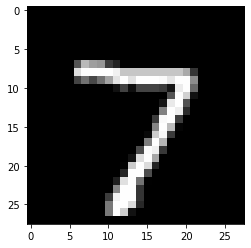

In [117]:
pixels = x_val[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [118]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        output = model(x_batch)
        loss = criterion(output, y_batch.to(torch.long))
        loss.backward()
        model.optim_.step()
        model.optim_.zero_grad()
    if epoch % 1 == 0:
        model.eval()
        with torch.no_grad():
            output_train = model(x_train)
            #print(output_train[0, :])
            # print(output_train.argmax(axis=1).shape)
            # print(y_train.shape)
            # print(type(output_train))
            accuracy_train = multi_acc(output_train, y_train)
            # print(accuracy_train)
            train_loss = criterion(output_train, y_train.to(torch.long))
            output_val = model(x_val)
            # print(output_val.argmax(axis=1))
            # print(y_val.to(torch.long))
            acc_val = multi_acc(output_val,y_val)
            val_loss = criterion(output_val, y_val.to(torch.long))
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f} \t train accuracy: {accuracy_train:.5f} \t val accuracy: {acc_val:.5f}")

Epoch: 0 	 Train loss:1.59790 	 Val loss: 1.58992 	 train accuracy: 85.27333 	 val accuracy: 85.90000
Epoch: 1 	 Train loss:1.58586 	 Val loss: 1.58092 	 train accuracy: 85.75166 	 val accuracy: 86.45000
Epoch: 2 	 Train loss:1.58365 	 Val loss: 1.57611 	 train accuracy: 85.26667 	 val accuracy: 85.92000
Epoch: 3 	 Train loss:1.57095 	 Val loss: 1.56597 	 train accuracy: 86.85333 	 val accuracy: 87.32000
Epoch: 4 	 Train loss:1.57295 	 Val loss: 1.56988 	 train accuracy: 85.20333 	 val accuracy: 85.68999
Epoch: 5 	 Train loss:1.56878 	 Val loss: 1.56637 	 train accuracy: 86.27500 	 val accuracy: 86.87000
Epoch: 6 	 Train loss:1.56631 	 Val loss: 1.56046 	 train accuracy: 87.50833 	 val accuracy: 88.07000
Epoch: 7 	 Train loss:1.56463 	 Val loss: 1.56161 	 train accuracy: 87.84000 	 val accuracy: 88.15000
Epoch: 8 	 Train loss:1.56436 	 Val loss: 1.55896 	 train accuracy: 88.34499 	 val accuracy: 88.82000
Epoch: 9 	 Train loss:1.56242 	 Val loss: 1.55851 	 train accuracy: 87.31167 	 val

In [119]:
x_val.shape

torch.Size([10000, 784])

In [120]:
preds_val = model.mc_predict(x_val, samples=2000).numpy() # this has 50 bundles of predictions where in each bundle there's prediction of one model
# print(preds_val[:,:,1].argmax(axis=1))
print(multi_acc(torch.Tensor(preds_val[:,:,1]), y_val))

tensor(87.1000)


In [121]:
print(y_val[0])

tensor(7.)


In [122]:
y_proba_Final = preds_val.mean(axis=2)

## As we can see in the following output that normal output of the softmax + droput is more certain then the MC dropout.

In [123]:
y_proba_Final.shape

(10000, 10)

In [124]:
print(multi_acc(torch.Tensor(y_proba_Final), y_val))

tensor(91.0900)


### We can see here the accuracy on performing MC dropout on base model increase roughly by 4%

# Now let's calculate uncertainties in the prediction

In [125]:
y_std = preds_val.std(axis = 2)
y_std

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.8657326e-03, ..., 7.8656255e-09,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.8334378e-01, 2.1781729e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.1846657e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

# Let's plot stuff

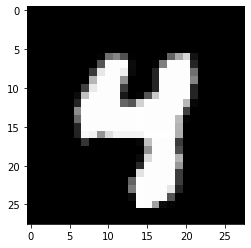

In [126]:
pixels = x_val[48].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [127]:
y_val[48]

tensor(4.)

In [128]:
preds_val[48,:,1]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       3.9521479e-09, 4.9503426e-30], dtype=float32)

In [129]:
y_proba_Final[48,:]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 9.7073050e-15, 0.0000000e+00, 0.0000000e+00,
       3.2773945e-01, 8.9666948e-02], dtype=float32)

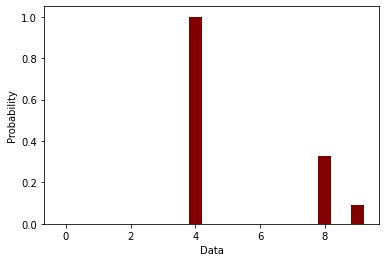

In [130]:
plt.bar([0,1,2,3,4,5,6,7,8,9], y_proba_Final[48,:], color ='maroon',
        width = 0.4) 
plt.ylabel('Probability')
plt.xlabel('Data');